In [1]:
import random
from collections import defaultdict
import time
import matplotlib.pyplot as plt
from functools import cache
import numpy as np
from sage.matroids.advanced import *

# Matroid Implementations

In [40]:
class TransversalMatroid:
    # a = Number of nodes on the left side, a = number of nodes on the right side
    # p = likelihood of a certain edge from some vertex on left to some vertex on right appearing
    def __init__(self, a, b, p):
        self.a = a; self.b = b; self.p = p
        
        self.A = [i for i in range(0, self.a)]
        self.B = [i for i in range(self.a, self.a + self.b)]
        self.source = -1
        self.sink = self.a + self.b
        self.adjacency = {vertex: [] for vertex in range(self.sink + 1)}
        self.adjacency[self.source] = [x for x in self.A]
        
        # Initialize flow-network that will be used to check if perfect matchings exist
        for v2 in self.B: self.adjacency[v2].append(self.sink)
        
        for v1 in self.A:
            for v2 in self.B:
                if random.random() < p: self.adjacency[v1].append(v2)
                    
        self.G = DiGraph(self.adjacency)
        #self.G.plot().show()
        
        for edge in self.G.edge_boundary(self.A):
            u = edge[0]; v = edge[1]
            self.G.set_edge_label(u, v, 1)
            
        for edge in self.G.edge_boundary(self.B):
            u = edge[0]; v = edge[1]
            self.G.set_edge_label(u, v, 1)
            
        self.n = a

    # Important: to make use of the cache, s needs to be immutable, e.g. a frozenset
    @cache
    def is_independent(self, s):
        for edge in self.G.edge_boundary([self.source]):
            u = edge[0]; v = edge[1]
            self.G.set_edge_label(u, v, 1 if v in s else 0)
        
        flow = self.G.flow(self.source, self.sink, use_edge_labels=True)
        assert flow <= len(s)
        return flow == len(s)
    
    # Finds a max-weight basis of X (that is a subset of 0, ..., n - 1)
    # weights should be a dictionary with key in X and value equivalent to weight of key
    def max_weight_independent(self, X=None, weights=None):
        # Use the greedy algorithm
        order = sorted(X, key=lambda item: weights[item], reverse=True)
        
        current = set()
        for e in order:
            current.add(e)
            if not self.is_independent(frozenset(current)):
                current.remove(e)

        return current
    
    # Return the span of X
    def closure(self, X):
        basis = self.max_weight_independent(X, {x: 0 for x in X})
        
        span = set()
        for i in range(self.n):
            if i in basis: span.add(i)
            else:
                basis.add(i)
                if not self.is_independent(frozenset(basis)): span.add(i)
                basis.remove(i)
                
        return span
    
    def rank(self):
        return len(max_weight_independent())
    
    def size(self):
        return self.n

# Random Matroid Generation

In [3]:
class RandomMatroid:
    def __init__(self, n):
        self.n = n
    
    # If not overriden, returns a random k-uniform matroid, where k is also uniform
    # between 1 and the universe size
    def rand_matroid(self):
        m = matroids.Uniform(random.randint(1, self.n), self.n)
        return m
    
    def gen(self, num_matroids):
        for _ in range(num_matroids):
            yield self.rand_matroid()

In [4]:
class GraphicRandomMatroid(RandomMatroid):
    def __init__(self, n):
        super().__init__(n)
        
    def rand_matroid(self):
        G = graphs.RandomGNM(random.randint(math.ceil((1+math.sqrt(1+8*self.n))/2), self.n), self.n)
        edges = [(e[0], e[1], i) for i, e in enumerate(G.edges())]
        return Matroid(graph=edges)

In [5]:
class LinearRandomMatroid(RandomMatroid):
    # Dependence probability p refers to the probability that a newly generated element will be 
    # independent from all previous elements. If the element isn't independent from all previous 
    # elements, then it will be chosen to be a random integer linear combination of a uniform 
    # subset of the previously generated elements
    #
    # All linear matroids will be over a finite field of the given order. To simulate real numbers,
    # make the order big compared to n
    def __init__(self, n, order=100, p=[0, 1]):
        super().__init__(n)
        self.order = order
        self.p = p
    
    # return one random linear matroid
    def rand_matroid(self):
        first_vector = [random.randint(0, self.order - 1) for j in range(self.n)]
        matrix = [first_vector]
        p = random.uniform(*self.p)
        for i in range(1, self.n):
            if random.random() < p:
                # generate a uniform random subset of [1, ..., i - 1]
                index_set = []
                for j in range(i):
                    if random.random() < 0.5: index_set.append(j)
                        
                if len(index_set) == 0: vector = [random.randint(0, self.order - 1) for j in range(self.n)]
                else:
                    vector = np.array([0 for j in range(self.n)])
                    for j in index_set:
                        coef = random.randint(1, self.order - 1)
                        to_add = np.array(matrix[j])
                        vector += to_add * coef
                        vector = vector % self.order
                        
                    vector = list(vector)
                        
            else: 
                vector = [random.randint(0, self.order - 1) for j in range(self.n)]
                
            matrix.append(vector)

        l = LinearMatroid(Matrix(GF(self.order), self.n, self.n, matrix).transpose())
        if verbose: print(l.rank())
        return l

In [6]:
class TransversalRandomMatroid(RandomMatroid):
    # a = Number of nodes on the left side, a = number of nodes on the right side
    # p = likelihood of a certain edge from some vertex on left to some vertex on right appearing
    def __init__(self, a=10, b=10, p=0.5):
        super().__init__(a)
        self.a = a
        self.b = b
        self.p = p
    
    # return one random transversal matroid
    def rand_matroid(self):
        return TransversalMatroid(self.a, self.b, self.p)

In [7]:
class GeneralRandomMatroid(RandomMatroid):
    def __init__(self, n):
        super().__init__(n)
        self.U = frozenset(range(n))
    
    def _isContained(self, AandB, Fr):
        if len(AandB) == 0: return True
        for C in Fr:
            if AandB.issubset(C): return True
        return False
    
    def rand_matroid(self):
        r = 0
        F = [set(frozenset())]
        while self.U not in F[r]:
            # generate covers
            F_next = set(frozenset())
            if r == 0:
                for a in self.U:
                    F_next.add(frozenset([a]))
            else:
                for A in F[r]:
                    for a in self.U - A:
                        x = set(A)
                        x.add(a)
                        F_next.add(frozenset(x))

            #enlarge
            if r != 0:
                # adjust the number of times this loop is performed to generate different matroids
                for _ in range(random.randint(0, self.n//2)):
                    A = set(random.choice(list(F_next)))
                    F_next.remove(A)
                    if len(list(self.U-A)) != 0:
                        A.add(random.choice(list(self.U-A)))
                    F_next.add(frozenset(A))

            # superpose
            isContained = False
            while not isContained:
                isContained = True
                not_contained = []
                for A in F_next:
                    for B in F_next:
                        if A == B: continue
                        if not self._isContained(A.intersection(B), F[r]): 
                            not_contained.append((A, B))
                            isContained = False
                for AB in not_contained:
                    A, B = AB
                    if A in F_next and B in F_next:
                        F_next.remove(A)
                        F_next.remove(B)
                        F_next.add(A.union(B))
            F.append(F_next)
            r += 1
    
        closed_sets = []
        for rank, X in enumerate(F):
            for Y in X:
                closed_sets.append((rank, Y))

        return Matroid(self.U, circuit_closures = closed_sets)

# Test Suite for AKW

## AKW Algorithm Implementation

In [8]:
# Import any algorithm implementations here
class FreeOrderMatroidAlgo:
    def __init__(self, matroid, weights):
        assert matroid.size() == len(weights)

        self.matroid = matroid
        self.weights = weights

class Conjecture(FreeOrderMatroidAlgo):
    def __init__(self, matroid, weights, sample_prob, verbose=False):
        super().__init__(matroid, weights)
        self.verbose = verbose
        
        # Sample S
        S = []
        self.P = set()
        for i in range(self.matroid.size()):
            if random.random() < sample_prob: 
                S.append((i, self.weights[i]))
            else: self.P.add(i)

        self.P = frozenset(self.P)
        S = dict(S)
        if self.verbose: print(f'{S = }')
        self.X = self.matroid.max_weight_independent(X=set(S.keys()), weights=S) # max-weight basis of S
        self.X = sorted(list(self.X), key=lambda i: self.weights[i], reverse=True)

        self.current_iteration = 0
        self.current_span = frozenset()

    def run_trial(self):
        cache(self.matroid.is_independent)
        
        total = 0
        remaining = set(self.P) # which elements haven't been seen yet
        #current_span = frozenset()
        A = frozenset() # store the answer

        Xset = set()
        for i, basis_elem in enumerate(self.X):
            # Check which elements in remaining are dependent
            Xset.add(basis_elem)
            candidates = []
            for element in remaining:
                Xset.add(element)
                if not self.matroid.is_independent(frozenset(Xset)): candidates.append(element)
                Xset.remove(element)
            random.shuffle(candidates)
            
            if self.verbose: print(f'{candidates = }')
            for y in candidates:
                remaining.remove(y)
                if self.weights[y] > self.weights[basis_elem]:
                    if self.matroid.is_independent(A.union(frozenset([y]))): 
                        A = A.union(frozenset([y]))
                        total += self.weights[y]
                        if self.verbose: print(f'{y = }')
            #current_span = next_span

        remaining = list(remaining)
        if self.verbose: print(f'{remaining = }')
        random.shuffle(remaining)
        for y in remaining:
            if self.matroid.is_independent(A.union(frozenset([y]))): 
                A = A.union(frozenset([y]))
                total += self.weights[y]

        return total, A

## Experiment Setup

In [9]:
# algo is assumed to be a FreeOrderMatroidAlgo. Returns averaged payoff over all trials
# weights will be a list of values of each item
def run_trials(num_trials, matroid, weights, verbose = False):
    sum = 0
    total_counts = defaultdict(lambda: 0)
    for _ in range(num_trials):
        algo = Conjecture(matroid, weights, exp(-1), verbose)
        weight, included = algo.run_trial()
        sum += weight
        if verbose: print(f'{included = }')
        for element in included: total_counts[element] += 1

    for key in total_counts: total_counts[key] = float(total_counts[key]) / num_trials
    return float(sum / num_trials), total_counts

In [10]:
def run_experiment(M, num_trials, weights = None, verbose = False):
    if weights is None: weights = [random.uniform(0, 1) for i in range(M.size())]

    start_time = time.time()
    val, freqs = run_trials(num_trials, M, weights, verbose)
    end_time = time.time()
    
    if verbose: print(f"Time to run {num_trials} trials is ", end_time - start_time)

    opt_indices = M.max_weight_independent(X=set(range(M.size())), weights = dict([(i, weight) for i, weight in enumerate(weights)]))
    opt_val = 0
    ratios = []
    
    for opt_index in opt_indices:
        ratios.append(freqs[opt_index])
        #if (freqs[opt_index] < exp(-1)):
            #print("Less than 1/e when ", M, opt_index)

    if verbose: print(ratios)
    return min(ratios)

In [39]:
def evaluate(rand_matroid, num_matroids, num_trials):
    results = []
    ranks = []
    for i, M in enumerate(rand_matroid.gen(num_matroids), 1):
        start = time.time()
        results.append(run_experiment(M, num_trials))
        ranks.append(M.rank())
        end = time.time()
        print(f'Matroid {i}/{num_matroids} completed in {round(end - start, 2)}s')
    return results, ranks

In [12]:
def plot(results, fname=None, fancy=False):
    if fancy:
        import seaborn as sns
        sns.set_style('whitegrid')
        sns.set_palette(sns.color_palette('deep'))
    bins = []
    for x in range(int(min(results)/((1/30)*float(exp(-1)))), int(max(results)/((1/30)*float(exp(-1))))+2):
        bins.append(x*(1/30)*float(exp(-1)))
    plt.hist(results, bins = bins, density=True)
    plt.axvline(x=float(exp(-1)), color = 'r', linestyle='dashed')
    plt.xlabel('Minimum Ratio of Optimal Secretaries', fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.tight_layout()
    if fname: plt.savefig(fname)
    plt.show()

In [13]:
import pickle

def save(results, fname):
    with open(fname, 'wb') as f:
        pickle.dump(results, f)
        
def load(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

## Evaluation of AKW

In [ ]:
# Experiment 1: 100 graphic matroids, size 101 (note: results in paper were not seeded accidentally)
random.seed(int(1001))
results1, ranks1 = evaluate(GraphicRandomMatroid(n=100), num_matroids=100, num_trials=1000)

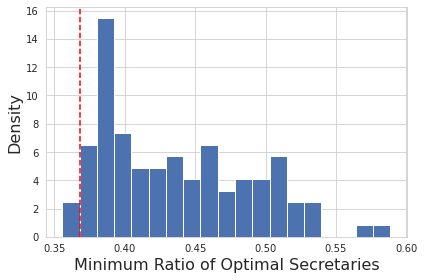

[0.364, 0.366, 0.367, 0.369, 0.37, 0.371, 0.374, 0.375, 0.378, 0.378, 0.379, 0.382, 0.382, 0.385, 0.387, 0.387, 0.387, 0.387, 0.388, 0.388, 0.389, 0.389, 0.389, 0.39, 0.391, 0.391, 0.391, 0.392, 0.392, 0.392, 0.393, 0.393, 0.394, 0.394, 0.396, 0.401, 0.402, 0.403, 0.404, 0.405, 0.405, 0.406, 0.411, 0.414, 0.416, 0.42, 0.422, 0.423, 0.425, 0.428, 0.428, 0.436, 0.437, 0.438, 0.439, 0.44, 0.44, 0.441, 0.442, 0.445, 0.446, 0.447, 0.449, 0.454, 0.456, 0.456, 0.457, 0.458, 0.461, 0.461, 0.462, 0.469, 0.476, 0.476, 0.478, 0.481, 0.484, 0.486, 0.486, 0.487, 0.494, 0.496, 0.497, 0.498, 0.5, 0.505, 0.505, 0.506, 0.511, 0.511, 0.513, 0.513, 0.516, 0.521, 0.526, 0.529, 0.537, 0.539, 0.565, 0.582]


In [18]:
plot(results1, fname = 'graphic.pdf', fancy = True)
save(results1, 'results1.obj')
print(sorted(results1))

In [216]:
# Experiment 2: 5 Transversal Matroids on a bipartite graph with nodes on left = 25, 
# nodes on right = 25, and edge inclusion probability 0.2
random.seed(int(1002))
results2, ranks2 = evaluate(TransversalRandomMatroid(25, 25, 0.2), num_matroids=5, num_trials=1000)

Matroid 1/5 completed in 179.54s
Matroid 2/5 completed in 191.72s
Matroid 3/5 completed in 186.53s
Matroid 4/5 completed in 197.52s
Matroid 5/5 completed in 205.53s


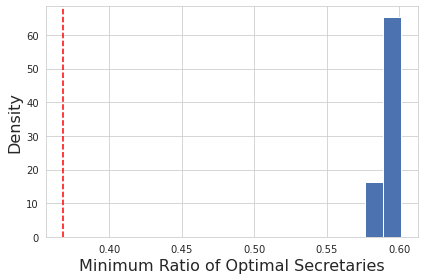

[0.586000000000000, 0.589000000000000, 0.595000000000000, 0.599000000000000, 0.599000000000000]


In [25]:
plot(results2, fancy = True)
save(results2, 'results2.obj')
print(sorted(results2))

In [218]:
# Experiment 3: 5 Transversal Matroids on a bipartite graph with nodes on left = 50, 
# nodes on right = 25, and edge inclusion probability 0.5
random.seed(int(1004))
results3, ranks3 = evaluate(TransversalRandomMatroid(50, 25, 0.5), num_matroids=5, num_trials=1000)

Matroid 1/5 completed in 9119.76s
Matroid 2/5 completed in 3773.59s
Matroid 3/5 completed in 4677.09s
Matroid 4/5 completed in 3688.02s
Matroid 5/5 completed in 3578.39s


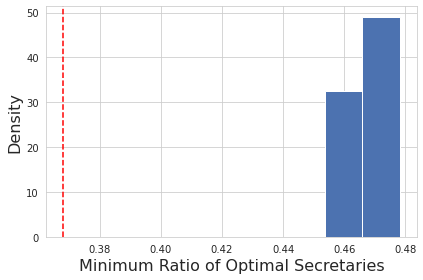

[0.462000000000000, 0.463000000000000, 0.474000000000000, 0.475000000000000, 0.476000000000000]


In [28]:
plot(results3, fancy = True)
save(results3, 'results3.obj')
print(sorted(results3))

In [ ]:
# Experiment 4: 10 Transversal Matroids on a bipartite graph with nodes on left = 50, 
# nodes on right = 25, and edge inclusion probability 0.5
random.seed(int(1005))
results4, ranks4 = evaluate(TransversalRandomMatroid(50, 25, 0.5), num_matroids=10, num_trials=1000)

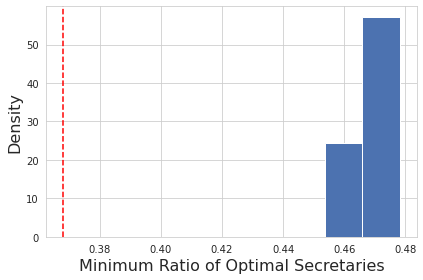

[0.463000000000000, 0.463000000000000, 0.463000000000000, 0.466000000000000, 0.466000000000000, 0.468000000000000, 0.470000000000000, 0.474000000000000, 0.474000000000000, 0.476000000000000]


In [31]:
plot(results4, fancy = True)
save(results4, 'results4.obj')
print(sorted(results4))

In [30]:
# Experiment 5: 10 Transversal Matroids on a bipartite graph with nodes on left = 25, 
# nodes on right = 50, and edge inclusion probability 0.3
random.seed(int(1005))
results5, ranks5 = evaluate(TransversalRandomMatroid(25, 50, 0.3), num_matroids=10, num_trials=1000)

Matroid 1/10 completed in 453.4s
Matroid 2/10 completed in 472.35s
Matroid 3/10 completed in 468.99s
Matroid 4/10 completed in 477.59s
Matroid 5/10 completed in 848.93s
Matroid 6/10 completed in 484.49s
Matroid 7/10 completed in 483.71s
Matroid 8/10 completed in 431.2s
Matroid 9/10 completed in 853.98s
Matroid 10/10 completed in 410.07s


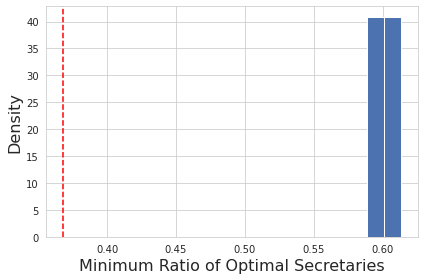

[0.594000000000000, 0.596000000000000, 0.599000000000000, 0.599000000000000, 0.600000000000000, 0.601000000000000, 0.603000000000000, 0.604000000000000, 0.606000000000000, 0.608000000000000]


In [33]:
plot(results5, fancy = True)
save(results5, 'results5.obj')
print(sorted(results5))

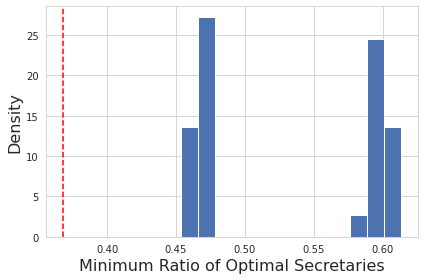

In [34]:
# Plot all 
plot(results2 + results3 + results4 + results5, fname='transversal.pdf', fancy=True)

In [ ]:
# Experiment 6: 100 Random Matroids with universe size = 15 (Note that these aren't actually
# uniformly at random chosen from all size-13 matroids; see Knuth's algorithm)
# (note: results in paper were not seeded accidentally)

random.seed(int(1006))
results6, ranks6 = evaluate(GeneralRandomMatroid(15), num_matroids=100, num_trials=1000)

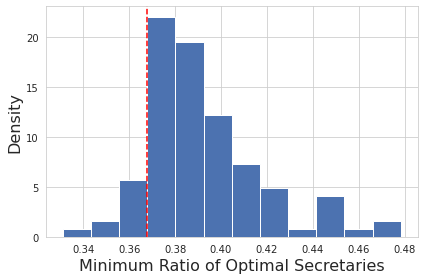

[0.342, 0.354, 0.355, 0.356, 0.363, 0.364, 0.365, 0.366, 0.367, 0.367, 0.368, 0.368, 0.369, 0.37, 0.37, 0.37, 0.371, 0.371, 0.371, 0.372, 0.373, 0.373, 0.373, 0.373, 0.374, 0.374, 0.375, 0.375, 0.375, 0.376, 0.376, 0.376, 0.377, 0.377, 0.377, 0.378, 0.379, 0.381, 0.381, 0.381, 0.382, 0.383, 0.383, 0.383, 0.383, 0.384, 0.384, 0.385, 0.385, 0.386, 0.386, 0.387, 0.387, 0.388, 0.388, 0.39, 0.39, 0.39, 0.391, 0.391, 0.392, 0.393, 0.394, 0.395, 0.397, 0.397, 0.398, 0.398, 0.399, 0.399, 0.4, 0.401, 0.402, 0.402, 0.404, 0.404, 0.406, 0.407, 0.408, 0.408, 0.409, 0.412, 0.415, 0.415, 0.416, 0.417, 0.422, 0.423, 0.426, 0.427, 0.428, 0.438, 0.442, 0.443, 0.448, 0.45, 0.452, 0.457, 0.471, 0.475]


In [36]:
plot(results6, fname = 'general.pdf', fancy = True)
save(results6, 'results6.obj')
print(sorted(results6))

In [ ]:
# Experiment 7: 100 Random Uniform Matroids with universe size = 200 (rank is also random)
random.seed(int(1007))
results7, ranks7 = evaluate(RandomMatroid(200), num_matroids=100, num_trials=1000)

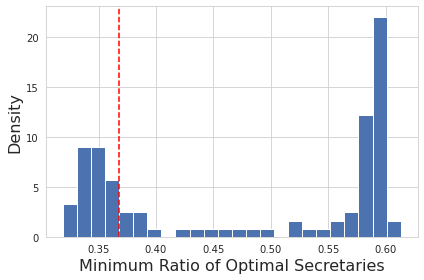

[0.325000000000000, 0.330000000000000, 0.331000000000000, 0.331000000000000, 0.332000000000000, 0.334000000000000, 0.334000000000000, 0.336000000000000, 0.339000000000000, 0.339000000000000, 0.340000000000000, 0.340000000000000, 0.341000000000000, 0.341000000000000, 0.342000000000000, 0.344000000000000, 0.344000000000000, 0.344000000000000, 0.344000000000000, 0.346000000000000, 0.350000000000000, 0.351000000000000, 0.353000000000000, 0.353000000000000, 0.355000000000000, 0.355000000000000, 0.357000000000000, 0.357000000000000, 0.359000000000000, 0.359000000000000, 0.359000000000000, 0.360000000000000, 0.363000000000000, 0.371000000000000, 0.372000000000000, 0.379000000000000, 0.384000000000000, 0.387000000000000, 0.388000000000000, 0.397000000000000, 0.427000000000000, 0.439000000000000, 0.443000000000000, 0.454000000000000, 0.470000000000000, 0.490000000000000, 0.495000000000000, 0.516000000000000, 0.524000000000000, 0.535000000000000, 0.541000000000000, 0.561000000000000, 0.561000000

In [38]:
plot(results7, fname = 'uniform.pdf', fancy = True)
save(results7, 'results7.obj')
print(sorted(results7))

In [ ]:
# Experiment 8: 300 random linear matroids in a finite field of order 37 with rank (somewhat)
# uniformly distributed between 1 and universe size 100
results8 = []
ranks8 = []

random.seed(int(1009))
res, rnk = evaluate(LinearRandomMatroid(100, order=37), num_matroids=100, num_trials=1000)
results8 += res
ranks8 += rnk

random.seed(int(1010))
res, rnk = evaluate(LinearRandomMatroid(100, order=37), num_matroids=100, num_trials=1000)
results8 += res
ranks8 += rnk

random.seed(int(1011))
res, rnk = evaluate(LinearRandomMatroid(100, order=37), num_matroids=100, num_trials=1000)
results8 += res
ranks8 += rnk

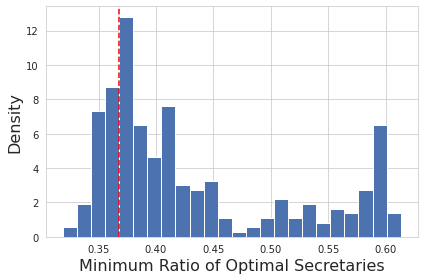

[0.326000000000000, 0.331000000000000, 0.333000000000000, 0.338000000000000, 0.340000000000000, 0.340000000000000, 0.341000000000000, 0.341000000000000, 0.342000000000000, 0.344000000000000, 0.344000000000000, 0.344000000000000, 0.344000000000000, 0.345000000000000, 0.345000000000000, 0.345000000000000, 0.346000000000000, 0.346000000000000, 0.347000000000000, 0.347000000000000, 0.348000000000000, 0.348000000000000, 0.348000000000000, 0.350000000000000, 0.351000000000000, 0.351000000000000, 0.351000000000000, 0.352000000000000, 0.353000000000000, 0.353000000000000, 0.353000000000000, 0.354000000000000, 0.354000000000000, 0.354000000000000, 0.354000000000000, 0.354000000000000, 0.356000000000000, 0.356000000000000, 0.357000000000000, 0.357000000000000, 0.359000000000000, 0.359000000000000, 0.359000000000000, 0.360000000000000, 0.360000000000000, 0.360000000000000, 0.360000000000000, 0.360000000000000, 0.361000000000000, 0.361000000000000, 0.361000000000000, 0.362000000000000, 0.362000000

In [52]:
plot(results8, fname = 'linear.pdf', fancy = True)
save(results8, 'results8.obj')
print(sorted(results8))

### Additional Exploration of Rank for Linear Matroids

In [46]:
import numpy as np
np_results = np.array(results8)
np_results_rank = np.array(ranks8)

results_q1 = np_results[np_results_rank < 20].tolist()
results_q2 = np_results[(np_results_rank >= 20) & (np_results_rank < 40)].tolist()
results_q3 = np_results[(np_results_rank >= 40) & (np_results_rank < 60)].tolist()
results_q4 = np_results[(np_results_rank >= 60) & (np_results_rank < 80)].tolist()
results_q5 = np_results[np_results_rank >= 80].tolist()

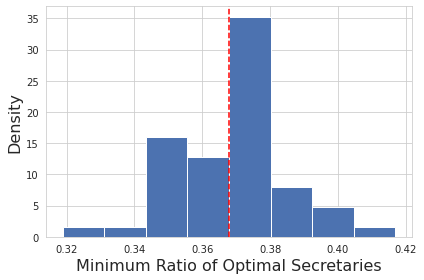

[0.326, 0.338, 0.344, 0.346, 0.348, 0.351, 0.351, 0.352, 0.353, 0.354, 0.354, 0.354, 0.357, 0.359, 0.359, 0.36, 0.36, 0.362, 0.365, 0.367, 0.368, 0.368, 0.371, 0.371, 0.372, 0.372, 0.372, 0.372, 0.373, 0.373, 0.373, 0.373, 0.374, 0.374, 0.374, 0.374, 0.375, 0.376, 0.376, 0.376, 0.376, 0.377, 0.384, 0.385, 0.386, 0.389, 0.39, 0.393, 0.396, 0.403, 0.405]


In [47]:
plot(results_q1, fname = 'linear_q1.pdf', fancy = True)
print(sorted(results_q1))

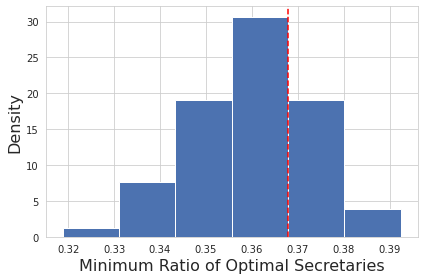

[0.331, 0.333, 0.34, 0.34, 0.341, 0.341, 0.342, 0.344, 0.344, 0.344, 0.345, 0.345, 0.345, 0.346, 0.347, 0.347, 0.348, 0.348, 0.35, 0.351, 0.353, 0.354, 0.356, 0.356, 0.357, 0.359, 0.36, 0.36, 0.36, 0.361, 0.361, 0.361, 0.362, 0.363, 0.364, 0.364, 0.364, 0.364, 0.365, 0.365, 0.365, 0.365, 0.365, 0.366, 0.366, 0.367, 0.368, 0.369, 0.371, 0.371, 0.371, 0.371, 0.372, 0.372, 0.372, 0.372, 0.374, 0.375, 0.378, 0.379, 0.38, 0.381, 0.387, 0.389]


In [48]:
plot(results_q2, fname = 'linear_q2.pdf', fancy = True)
print(sorted(results_q2))

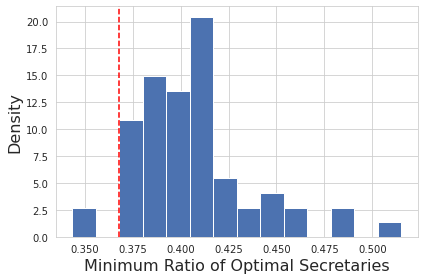

[0.353, 0.354, 0.369, 0.371, 0.374, 0.376, 0.378, 0.378, 0.378, 0.38, 0.381, 0.382, 0.384, 0.386, 0.387, 0.387, 0.392, 0.392, 0.392, 0.392, 0.392, 0.393, 0.394, 0.396, 0.396, 0.398, 0.401, 0.401, 0.403, 0.404, 0.404, 0.405, 0.405, 0.406, 0.406, 0.407, 0.407, 0.408, 0.408, 0.411, 0.411, 0.412, 0.413, 0.414, 0.414, 0.416, 0.418, 0.418, 0.425, 0.426, 0.433, 0.434, 0.443, 0.447, 0.452, 0.459, 0.46, 0.479, 0.483, 0.513]


In [49]:
plot(results_q3, fname = 'linear_q3.pdf', fancy = True)
print(sorted(results_q3))

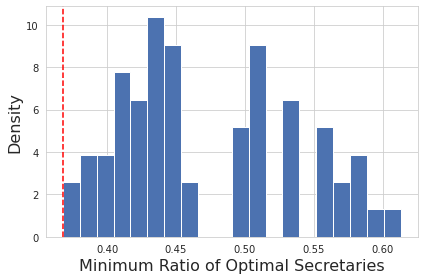

[0.368, 0.369, 0.382, 0.384, 0.387, 0.395, 0.396, 0.398, 0.406, 0.408, 0.412, 0.412, 0.413, 0.415, 0.42, 0.421, 0.424, 0.427, 0.429, 0.432, 0.433, 0.434, 0.436, 0.438, 0.439, 0.439, 0.441, 0.443, 0.444, 0.445, 0.445, 0.446, 0.447, 0.45, 0.46, 0.46, 0.491, 0.494, 0.5, 0.501, 0.504, 0.505, 0.505, 0.508, 0.509, 0.511, 0.513, 0.529, 0.533, 0.533, 0.538, 0.538, 0.553, 0.557, 0.559, 0.564, 0.567, 0.572, 0.58, 0.581, 0.582, 0.596, 0.605]


In [50]:
plot(results_q4, fname = 'linear_q4.pdf', fancy = True)
print(sorted(results_q4))

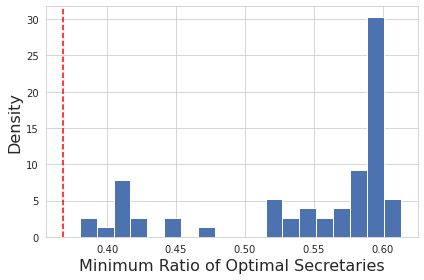

[0.382, 0.383, 0.394, 0.406, 0.407, 0.408, 0.412, 0.413, 0.414, 0.417, 0.419, 0.442, 0.45, 0.472, 0.517, 0.518, 0.519, 0.52, 0.535, 0.536, 0.541, 0.543, 0.548, 0.555, 0.562, 0.569, 0.574, 0.574, 0.578, 0.579, 0.583, 0.583, 0.583, 0.588, 0.588, 0.59, 0.59, 0.591, 0.591, 0.591, 0.592, 0.592, 0.592, 0.594, 0.594, 0.594, 0.595, 0.595, 0.595, 0.596, 0.597, 0.597, 0.597, 0.598, 0.598, 0.599, 0.599, 0.6, 0.602, 0.603, 0.604, 0.605]


In [51]:
plot(results_q5, fname = 'linear_q5.pdf', fancy = True)
print(sorted(results_q5))